In [76]:
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib notebook
from mpl_toolkits.mplot3d import axes3d
import random

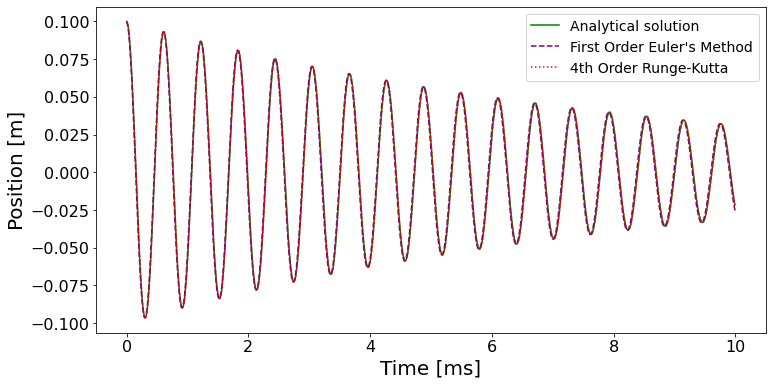

In [77]:
import nbimporter
%run DampedOscillator.ipynb

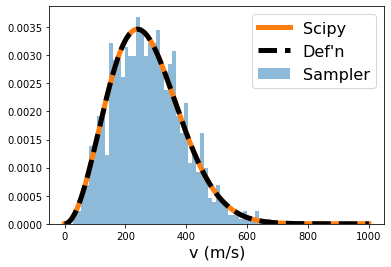

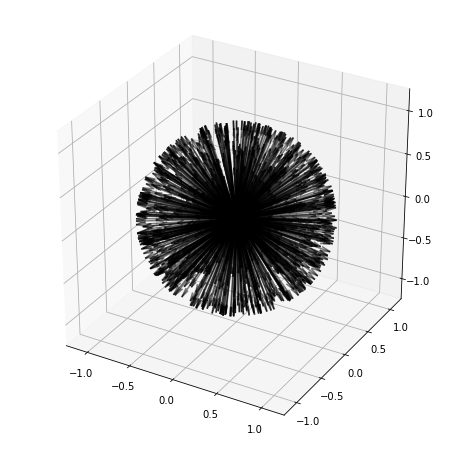

In [78]:
%run MaxwellBoltzmann.ipynb

# Full 2D+ MOT Simulation

In [4]:
# Physical Constants
hbar = 1.055 * 10**(-34) # Js, reduced Planck's constant
light_c = 2.998 * 10**(8) # m/s
BohrMag = 9.27401008 * 10**(-24) # A m^2

# Rubidium-87 Specifics
mass_Rb87 = 1.4431609 * 10**(-25) # kg
gamma = 6.06 * 10**(6) # Hz, natural line width (FWHM of D2 transition of Rb-87). Szulc.
omega_D2 = 2*np.pi* 384.2304844685 * 10**(12) # Hz. Steck.

# Apparatus
tube_diam = 2 * 10**(-3) # meters, differential pumping tube diameter
tube_length = 3 * 10**(-2) # meters, differential pumping tube length
bgrad_x = 0.11 # T/m, equal to 11 G/cm.
bgrad_y = bgrad_x
bgrad_z = 0

# Cell dimensions
x_len = 0.04 # m
y_len = 0.04 # m
z_len = 0.1  #m

# Beams
cooling_waist = 50 * 10**(-3) # m. Page 54 of Szulc uses elliptical profile. I use circular cross section.
push_waist = 9 * 10**(-3) # m. Page 54 Szulc.

# Optimize
s0 = 12 #12 # Optimal = 12.
det_x = -1.5*gamma # Optimal = -1.5gamma
det_y = -1.5*gamma # Optimal = -1.5gamma
det_z = -1.5*gamma

det_push = -1.5*gamma
det_counter = -3.5*gamma

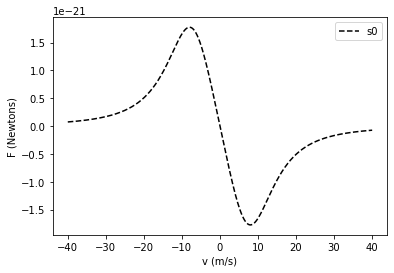

In [7]:
# Check F vs. v profile for this param set.
varr = np.linspace(-40**1, 40**1, 10000)
x = 0
plus, minus = getDeltaPM(x, varr, det_x, bgrad_x)

force = radiativeHelper(plus, minus, det_x, s0)

plt.plot(varr, force, label="s0", ls="--", c="k")
plt.xlabel("v (m/s)")
plt.ylabel("F (Newtons)")
plt.legend()

## Implementation Info
#### Storage
Positions and velocities of particles are stored as a numpy array of length 3. All functions take in a parameter called axis which must specify "x", "y", or "z". 

#### Geometry
Cooling should occur in the xy plane. 

## Forces

The radiative force takes the form of the following with $e^{-2r^2/w^2}$ representing its Gaussian profile.
$$ \vec{F}_{\pm} =s_0 e^{-2r^2/w^2}\frac{\hbar \gamma/2}{1 + s_0e^{-2r^2/w^2} + (2\Delta_{\pm}/\gamma)^2}\cdot\frac{\omega_{D2} + \delta}{c}\hat{k}_{\pm} $$
where for the x-axis, for example:
$$ \Delta_{\pm} = \delta \mp \frac{kv_x}{2\pi} \mp \text{sign}(x)\frac{|\tilde{\mu}B(x)|}{2\pi\hbar}$$
where $\tilde{\mu} = \frac{2}{3}\mu_B$ for the D2 line of Rb-87, and $B(x) = bx$, $b>0$.

## Functions for the computation of overall detunings and forces

In [83]:
# Overall detuning for counter-push beam.
def getDeltaPlus(x,v,det,bgrad):
    term1 = det
    term2 = (((omega_D2 + 2*np.pi*det)/(light_c))*v)/(2*np.pi)
    term3 = np.sign(x)*np.abs((2/3)*BohrMag*bgrad*x)/(2*np.pi*hbar)
    Delta_plus = term1 - term2 - term3

    return Delta_plus

# Overall detuning for push beam.
def getDeltaMinus(x,v,det,bgrad):
    term1 = det
    term2 = (((omega_D2 + 2*np.pi*det)/(light_c))*v)/(2*np.pi)
    term3 = np.sign(x)*np.abs((2/3)*BohrMag*bgrad*x)/(2*np.pi*hbar)
    Delta_plus = term1 - term2 - term3
    Delta_minus = term1 + term2 + term3

    return Delta_minus

# Get the overall detunings for the push and counterpush beams.
def getDeltaPMpusher(x, v, det_push, det_counter, bgrad):
    return getDeltaPlus(x,v,det_push, bgrad), getDeltaMinus(x,v,det_counter, bgrad)

# Get the overlal detunings for the cooling beams.
def getDeltaPM(x, v, det, bgrad):
    term1 = det
    term2 = (((omega_D2 + 2*np.pi*det)/(light_c))*v)/(2*np.pi)
    term3 = np.sign(x)*np.abs((2/3)*BohrMag*bgrad*x)/(2*np.pi*hbar)
    Delta_plus = term1 - term2 - term3
    Delta_minus = term1 + term2 + term3
    return Delta_plus, Delta_minus

# Helper function for forceRadiative function.
def radiativeHelper(Delta_plus, Delta_minus, det, s_adjusted):
    k = (omega_D2 + 2*np.pi*det)/(light_c)
    F_plus = k * (hbar*s_adjusted*(gamma/2))/(1 + s_adjusted + (2*Delta_plus/gamma)**2)
    F_minus = k * (hbar*s_adjusted*(gamma/2))/(1 + s_adjusted + (2*Delta_minus/gamma)**2)
    return F_plus - F_minus

# Helper function for forcePush function.
def pushHelper(Delta_plus, Delta_minus, det_push, det_counter, s_adjusted):
    kcounter = (omega_D2 + 2*np.pi*det_push)/(light_c) # counter push
    kpush =  (omega_D2 + 2*np.pi*det_counter)/(light_c) # push 
    F_plus = kcounter * (hbar*s_adjusted*(gamma/2))/(1 + s_adjusted + (2*Delta_plus/gamma)**2) # counter push
    F_minus = kpush * (hbar*s_adjusted*(gamma/2))/(1 + s_adjusted + (2*Delta_minus/gamma)**2) # push
    return F_plus, F_minus

# dets = [det_push, det_counter]
def forcePush(x0, v0, dets, bgrad, s_adj):
    det_push = dets[0]
    det_counter = dets[1]
    # Compute Delta_{pm}. No magnetic field in this direction.
    Delta_plus, Delta_minus = getDeltaPMpusher(x0, v0, det_push, det_counter, bgrad_z)
    # Compute Force 
    fplus, fminus = pushHelper(Delta_plus, Delta_minus, det_push, det_counter, s_adj)
    return fplus - fminus 

def forceRad(x0, v0, det, bgrad, s_adj):    
    # Compute Delta_{pm}
    Delta_plus, Delta_minus = getDeltaPM(x0, v0, det, bgrad)
    # Compute Force
    force = radiativeHelper(Delta_plus, Delta_minus, det, s_adj)
    return force

## Simulation tools (defining a simulation step, RK4 algorithm, etc.)

In [16]:
# One step of 4th Order Runge-Kutte algorithm.
def RK4_step(force, xn, yn, zn, vn, axis, dt, m=mass_Rb87):
        # Initialize parameters
        r_squared = np.NaN
        waist = np.NaN
        det = np.NaN
        bgrad = np.NaN
        
        # Position variable
        pn = -10e9
        
        if axis == 0:
            r_squared = yn**2 + zn**2
            waist = cooling_waist
            det = det_x
            bgrad = bgrad_x
            pn = xn
        elif axis == 1:
            r_squared = xn**2 + yn**2
            waist = cooling_waist
            det = det_y
            bgrad = bgrad_y
            pn = yn
        elif axis == 2:
            r_squared = xn**2 + yn**2
            waist = push_waist
            det = [det_push, det_counter]
            bgrad = bgrad_z
            pn = zn
            
        # Make s_adj with the waist:
        s_adj = s0 * np.exp(-2*r_squared/(waist**2))
        
        # Make an RK4 STEP.
        K1 = force(pn, vn, det, bgrad, s_adj)/m
        L1 = vn
        
        K2 = force(pn + dt*L1/2, vn + dt*K1/2, det, bgrad, s_adj)/m
        L2 = vn + dt*K1/2
        
        K3 = force(pn + dt*L2/2, vn + dt*K2/2, det, bgrad, s_adj)/m
        L3 = vn + dt*K2/2
        
        K4 = force(pn + dt*L3, vn + dt*K3, det, bgrad, s_adj)/m
        L4 = vn + dt*K3
        
        # Update xn and vn
        pn = pn + (dt/6)*(L1 + 2*L2 + 2*L3 + L4)
        vn = vn + (dt/6)*(K1 + 2*K2 + 2*K3 + K4)
        
        return pn, vn, K1*m # return force for logging

# One step of the simulation of a particle's trajectory.
# Requires the use of RK4_Step for each direction.
def step(forceRad, forcePush, vec_x, vec_v, dt):
    # Unpack vec_x
    xn, yn, zn = vec_x
    # Unpack vec_v
    vxn, vyn, vzn = vec_v
    
    # Time-evolve
    # x-direction
    xn, vxn, force_x = RK4_step(forceRad, xn, yn, zn, vxn, axis=0, dt=dt)
    # y-direction
    yn, vyn, force_y = RK4_step(forceRad, xn, yn, zn, vyn, axis=1, dt=dt)
    # z-direction
    zn, vzn, force_z = RK4_step(forcePush, xn, yn, zn, vzn, axis=2, dt=dt)
    
    return np.array([xn, yn, zn]), np.array([vxn, vyn, vzn]), np.array([force_x, force_y, force_z])
    
# Simulate a particle's trajectory for a given amount of time.
# Initial position and velocity vectors: vec_x, vec_v
def simulate(vec_x, vec_v, dt=10 * 10**(-6), num_timesteps=100000, m=mass_Rb87):
    # Storage
    positions = []
    positions.append(np.copy(vec_x))
    velocities = []
    velocities.append(np.copy(vec_v))
    times = []
    times.append(0)
    forces = []
    
    # Flag for success. 1 =  True. 0 = False.
    success = 0 # Initialize to 0 if one wants onnly the atoms that reach science chamber.
                # Initialize to 1 if one wants atoms that did not collide with wall AND science chamber atoms
    
    for j in range(0, num_timesteps):
        vec_x, vec_v, vec_force = step(forceRad, forcePush, vec_x, vec_v, dt)    
        positions.append(np.copy(vec_x))
        velocities.append(np.copy(vec_v))
        times.append((j+1) * dt)
        forces.append(np.copy(vec_force))
        
        if aboveCell(vec_x):
            if checkTubeCollision(vec_x):
                success=0
                break
            else: # if in tube and no collision, check if reached science chamber.
                if reachedScienceChamber(vec_x):
                    success=1
                    break
                    
        elif checkCollision(vec_x): # If it's not in the tube, it checks for cell collision.
            success=0
            break
        
    return np.array(positions), np.array(velocities), np.array(times), np.array(forces), success

### Boundary checks (collisions, reach science chamber, etc.)

In [ ]:
# Return true if science chamber z (z_len/2 + tube_length) is acquired
def reachedScienceChamber(vec_x):
    x, y, z = vec_x
    if z > ((z_len/2) + tube_length):
        return True

# Return true if its above the cell.
def aboveCell(vec_x):
    x, y, z = vec_x
    if z > z_len/2:
        return True

# Assumption is that it the atom is in the tube (above cell)
def checkTubeCollision(vec_x):
    x, y, z = vec_x
    # Check collision in tube:
    if np.sqrt(x**2 + y**2) > tube_diam/2:
        return True 

# Return true if collision within the cell.
def checkCollision(vec_x):
    x, y, z = vec_x
    # It's in the cell, check for collisions.
    if np.abs(x) > x_len/2 or np.abs(y) > y_len/2 or z < -z_len/2:
        return True
    else:
        return False

## Simulation Cell

In [84]:
N_sim = 100000

# Should a cut velocity be activated?
# This means no trajectory is simulated with initial v_samp > v_cut.
ActivateCutVelocity = False
vcut = 100 #m/s

# Data storage
pos_rec = []
vel_rec = []
times_rec = []
forces_rec = []
successes = 0
success_index = []

# Loop to simulate N_sim trajectories
for n in range(0, N_sim):
    # Sample a velocity vector from MBD
    smp = sampleVelocityVec()
    
    # Find a velocity vector below the cut, if requested.
    if ActivateCutVelocity:
        while np.linalg.norm(smp) > vcut:
            smp = sampleVelocityVec()
    
    # Initialize atom
    vec_x = np.array([0,0,0])
    vec_v = np.array([smp[0], smp[1], smp[2]]) # Sampled v from Maxwell-Boltzmann
    
    # Simulate the atom's trajectory
    pos, vel, times, forces, success = simulate(vec_x, vec_v, num_timesteps=10000)
    
    # Save data.
    if success == 1:
        successes += 1
        success_index.append(n)
        print("Success at n = ", n)
    pos_rec.append(pos)
    vel_rec.append(vel)
    forces_rec.append(forces)
    times_rec.append(times)
    
    # Update user with progress
    if n % int(N_sim/100) == 0:
        print("Done with run ", n)

print("Successful: ", successes)
print("Success index: ", success_index)

Done with run  0
Done with run  1000
Done with run  2000
Done with run  3000
Success at n =  3443
Done with run  4000
Done with run  5000
Success at n =  5058
Done with run  6000
Done with run  7000
Done with run  8000
Done with run  9000
Success at n =  9675
Done with run  10000
Done with run  11000
Success at n =  11604
Done with run  12000
Success at n =  12088
Done with run  13000
Done with run  14000
Done with run  15000
Success at n =  15746
Success at n =  15752
Done with run  16000
Done with run  17000
Done with run  18000
Done with run  19000
Done with run  20000
Success at n =  20397
Done with run  21000
Success at n =  21182
Success at n =  21628
Done with run  22000
Success at n =  22267
Done with run  23000
Success at n =  23272
Success at n =  23366
Done with run  24000
Done with run  25000
Done with run  26000
Done with run  27000
Success at n =  27159
Success at n =  27263
Done with run  28000
Success at n =  28807
Done with run  29000
Success at n =  29178
Done with ru

### Looking at one science chamber atom's trajectory:

Initial velocity:  [-12.88379587 -13.23344485   9.66510459]


Text(0, 0.5, 'F_z (N)')

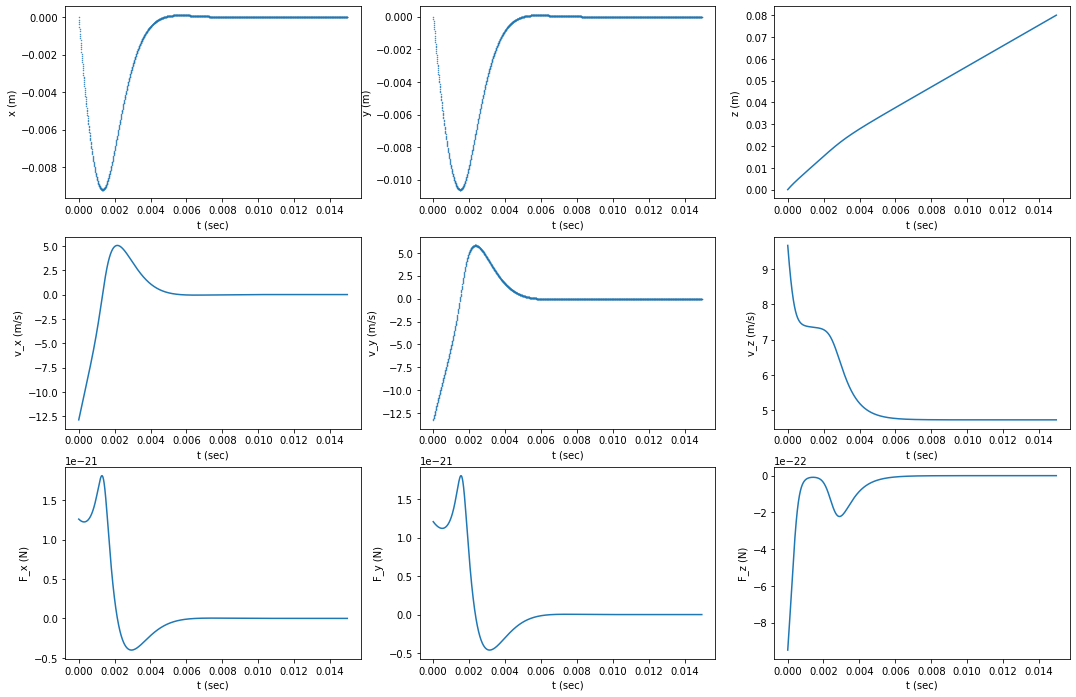

In [85]:
# positions
fig, ax = plt.subplots(3, 3, figsize=(18, 12))

sim = True
if sim:
    nnn=success_index[0]
    pos = pos_rec[nnn]
    vel = vel_rec[nnn]
    print("Initial velocity: ", vel[0])
    forces = forces_rec[nnn]
    times = times_rec[nnn]

# x-pos (TOP LEFT)
ax[0,0].scatter(times, pos[:, 0], label="RK4", s=0.2)
ax[0,0].set_xlabel("t (sec)")
ax[0,0].set_ylabel("x (m)")

# v_x (middle LEFT)
ax[1,0].plot(times, vel[:, 0], label="RK4")
ax[1,0].set_xlabel("t (sec)")
ax[1,0].set_ylabel("v_x (m/s)")

# F_x (bottom LEFT)
ax[2,0].plot(times[1:], forces[:, 0], label="RK4")
ax[2,0].set_xlabel("t (sec)")
ax[2,0].set_ylabel("F_x (N)")

# y-pos (TOP CENTER)
ax[0, 1].scatter(times, pos[:, 1], label="RK4", s=0.2)
ax[0, 1].set_xlabel("t (sec)")
ax[0, 1].set_ylabel("y (m)")

# v_y (BOTTOM CENTER)
ax[1, 1].scatter(times, vel[:, 1], label="RK4", s=0.2)
ax[1, 1].set_xlabel("t (sec)")
ax[1, 1].set_ylabel("v_y (m/s)")

# F_y (bottom middle)
ax[2,1].plot(times[1:], forces[:, 1], label="RK4")
ax[2,1].set_xlabel("t (sec)")
ax[2,1].set_ylabel("F_y (N)")


# z-pos (TOP RIGHT)
ax[0, 2].plot(times, pos[:, 2], label="RK4")
ax[0, 2].set_xlabel("t (sec)")
ax[0, 2].set_ylabel("z (m)")

# v_z (BOTTOM RIGHT)
ax[1, 2].plot(times, vel[:, 2], label="RK4")
ax[1, 2].set_xlabel("t (sec)")
ax[1, 2].set_ylabel("v_z (m/s)")

# F_z (bottom middle)
ax[2,2].plot(times[1:], forces[:, 2], label="RK4")
ax[2,2].set_xlabel("t (sec)")
ax[2,2].set_ylabel("F_z (N)")

### The initial and exit velocities of atoms that reach the science chamber

Text(0.5, 0, 'Exit $v_z$ (m/s)')

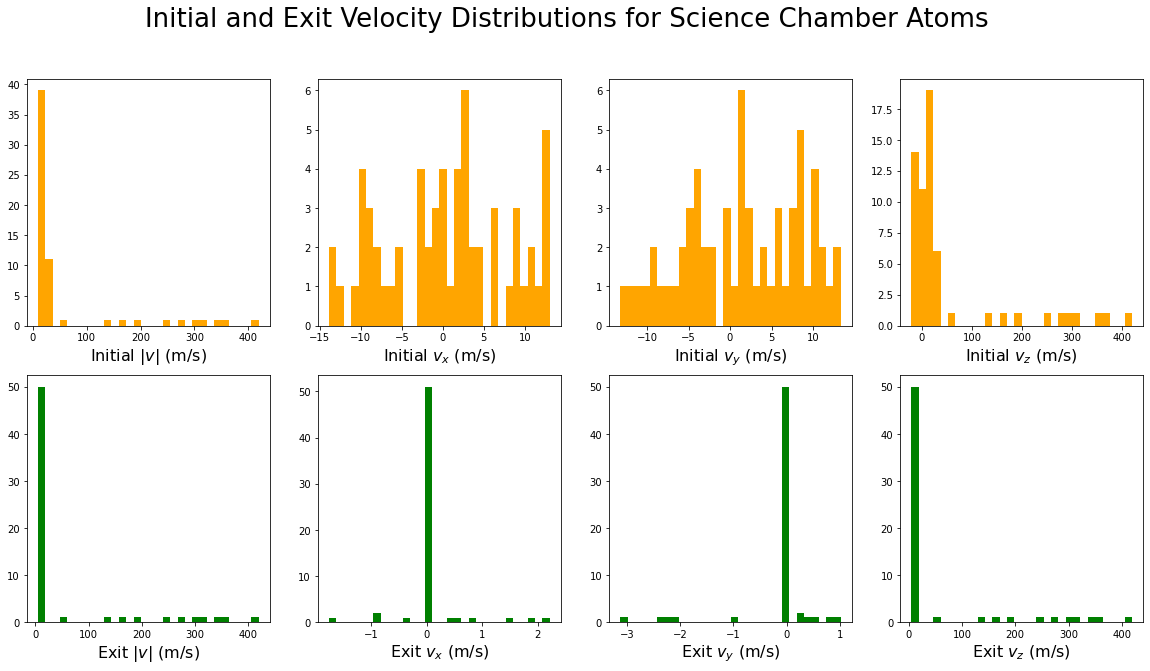

In [86]:
# Make a histogram of the trapped speeds
speeds = []
vxs = []
vys = []
vzs = []

# Exit
espeeds = []
evxs = [] 
evys = []
evzs = []

for n in success_index:
    # Collect initial velocities
    vel = vel_rec[n][0]
    spd = np.sqrt(np.sum(vel**2))
    speeds.append(spd)
    vxs.append(vel[0])
    vys.append(vel[1])
    vzs.append(vel[2])
    
    # Collect exit velocities
    vel = vel_rec[n][-1]
    espd = np.sqrt(np.sum(vel**2))
    espeeds.append(espd)
    evxs.append(vel[0])
    evys.append(vel[1])
    evzs.append(vel[2])
    
# Plotting:
fig, ax = plt.subplots(2,4, figsize=(20,10))
fig.suptitle("Initial and Exit Velocity Distributions for Science Chamber Atoms", fontsize=26)


# Initial
ax[0][0].hist(speeds, bins=30, label="speed", color="orange")
ax[0][0].set_xlabel(r"Initial $|v|$ (m/s)", fontsize=16)

ax[0][1].hist(vxs, bins=30, label="vx", color="orange")
ax[0][1].set_xlabel(r"Initial $v_x$ (m/s)", fontsize=16)

ax[0][2].hist(vys, bins=30, label="vy", color="orange")
ax[0][2].set_xlabel(r"Initial $v_y$ (m/s)", fontsize=16)

ax[0][3].hist(vzs, bins=30, label="vz", color="orange")
ax[0][3].set_xlabel(r"Initial $v_z$ (m/s)", fontsize=16)

# Exit
ax[1][0].hist(espeeds, bins=30, label="speed", color="green")
ax[1][0].set_xlabel(r"Exit $|v|$ (m/s)", fontsize=16)

ax[1][1].hist(evxs, bins=30, label="vx", color="green")
ax[1][1].set_xlabel(r"Exit $v_x$ (m/s)", fontsize=16)

ax[1][2].hist(evys, bins=30, label="vy", color="green")
ax[1][2].set_xlabel(r"Exit $v_y$ (m/s)", fontsize=16)

ax[1][3].hist(evzs, bins=30, label="vz", color="green")
ax[1][3].set_xlabel(r"Exit $v_z$ (m/s)", fontsize=16)

### Visualizing the trajectories of atoms that made it to the science chamber

Text(0.5, 0, 'z (m)')

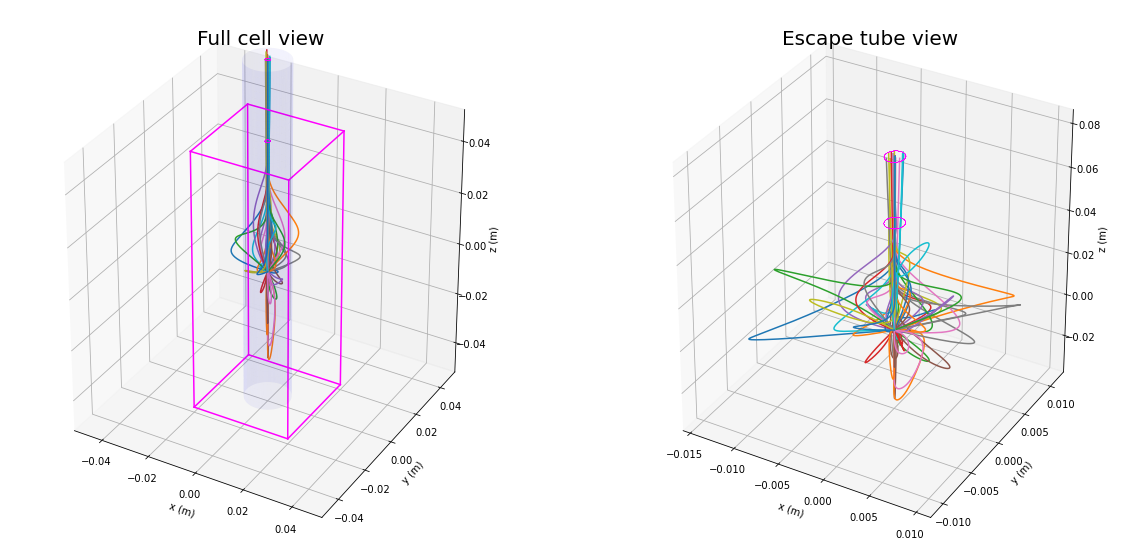

In [87]:
fig = plt.figure(figsize=(20,10)) 
ax = fig.add_subplot(121, projection='3d')
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
ax.set_zlabel("z (m)")
ax.set_title("Full cell view", fontsize=20)

show = True
successfulOnly = True
if show:
    if successfulOnly:
        for n in success_index:
            pos = pos_rec[n]
            ax.plot(pos[:, 0], pos[:, 1], pos[:, 2])
    else:
        plotN = 10
        for i in range(0, plotN):
            pos = pos_rec[random.randint(0, N_sim-1)]
            ax.plot(pos[:, 0], pos[:, 1], pos[:, 2])

#  [95, 191, 316, 436, 478, 616, 987]
sim = False
nnn = success_index[0] # Plot this index
if sim:
    pos = pos_rec[nnn]
    vel = vel_rec[nnn]
    forces = forces_rec[nnn]
    times = times_rec[nnn]
    ax.plot(pos[:, 0], pos[:, 1], pos[:, 2])
    
    
# Build beams:
showBeams = True
if showBeams:
    # Cylinder | https://stackoverflow.com/questions/26989131/add-cylinder-to-plot
    xcyl = np.linspace(-push_waist, push_waist, 1000)
    zcyl = np.linspace(-z_len/2, tube_length + z_len/2, 1000)
    Xc, Zc = np.meshgrid(xcyl, zcyl)
    Yc = np.sqrt(push_waist**2-Xc**2)
    ax.plot_surface(Xc, Yc, Zc, alpha=0.05, color="blue")
    ax.plot_surface(Xc, -Yc, Zc, alpha=0.05, color="blue")
    
    #xcyl = np.linspace(-cooling_waist, cooling_waist, 1000)
    #zcyl = np.linspace(-x_len, x_len, 1000)
    #Xc, Zc = np.meshgrid(xcyl, zcyl)
    #Yc = np.sqrt(cooling_waist**2-Xc**2)
    #ax.plot_surface(Zc, Xc, Yc, alpha=0.05, color="blue")
    #ax.plot_surface(Zc, Xc, -Yc, alpha=0.05, color="blue")
        
# Build cell:
showCell = True
showTube = True
if showCell:
    cell_x = np.linspace(-x_len/2, x_len/2, 1000)
    ax.plot(cell_x, (y_len/2)*np.ones_like(cell_x), (z_len/2)*np.ones_like(cell_x), c="magenta")
    ax.plot(cell_x, (y_len/2)*np.ones_like(cell_x), -(z_len/2)*np.ones_like(cell_x), c="magenta")
    ax.plot(cell_x, -(y_len/2)*np.ones_like(cell_x), (z_len/2)*np.ones_like(cell_x), c="magenta")
    ax.plot(cell_x, -(y_len/2)*np.ones_like(cell_x), -(z_len/2)*np.ones_like(cell_x), c="magenta")
    cell_y = np.linspace(-y_len/2, y_len/2, 1000)
    ax.plot((x_len/2)*np.ones_like(cell_x), cell_y, (z_len/2)*np.ones_like(cell_x), c="magenta")
    ax.plot((x_len/2)*np.ones_like(cell_x), cell_y, -(z_len/2)*np.ones_like(cell_x), c="magenta")
    ax.plot(-(x_len/2)*np.ones_like(cell_x), cell_y, (z_len/2)*np.ones_like(cell_x), c="magenta")
    ax.plot((-x_len/2)*np.ones_like(cell_x), cell_y, -(z_len/2)*np.ones_like(cell_x), c="magenta")
    cell_z = np.linspace(-z_len/2, z_len/2, 1000)
    ax.plot((x_len/2)*np.ones_like(cell_x), (y_len/2)*np.ones_like(cell_x), cell_z, c="magenta")
    ax.plot((x_len/2)*np.ones_like(cell_x), -(y_len/2)*np.ones_like(cell_x), cell_z, c="magenta")
    ax.plot(-(x_len/2)*np.ones_like(cell_x), (y_len/2)*np.ones_like(cell_x), cell_z, c="magenta")
    ax.plot((-x_len/2)*np.ones_like(cell_x), -(y_len/2)*np.ones_like(cell_x), cell_z, c="magenta")

    
    # Set limits for first plot
    limm = 0.5*z_len
    ax.set_xlim(-limm, limm)
    ax.set_ylim(-limm, limm)
    ax.set_zlim(-limm, limm)


# Build hole
if showTube:
    # Tube left fig
    uuu = np.linspace(0, 100, 10000)
    ax.plot((tube_diam/2)*np.cos(uuu), (tube_diam/2)*np.sin(uuu), z_len/2, c="magenta", lw=0.1)
    ax.plot((tube_diam/2)*np.cos(uuu), (tube_diam/2)*np.sin(uuu), z_len/2 + tube_length, c="magenta", lw=0.1)
    
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    # Plot:
    if show:
        if successfulOnly:
            for n in success_index:
                pos = pos_rec[n]
                ax.plot(pos[:, 0], pos[:, 1], pos[:, 2])
        else:
            plotN = 10
            for i in range(0, plotN):
                pos = pos_rec[random.randint(0, N_sim-1)]
                ax.plot(pos[:, 0], pos[:, 1], pos[:, 2])
    if sim:
        pos = pos_rec[nnn]
        vel = vel_rec[nnn]
        forces = forces_rec[nnn]
        times = times_rec[nnn]
        ax.plot(pos[:, 0], pos[:, 1], pos[:, 2])

    # Tube right fig
    uuu = np.linspace(0, 100, 10000)
    ax.plot((tube_diam/2)*np.cos(uuu), (tube_diam/2)*np.sin(uuu), z_len/2, c="magenta", lw=0.1)
    ax.plot((tube_diam/2)*np.cos(uuu), (tube_diam/2)*np.sin(uuu), z_len/2 + tube_length, c="magenta", lw=0.1)
    
    tubeCenter = False
    if tubeCenter:
        ax.set_xlim(-0.007*z_len, 0.007*z_len)
        ax.set_ylim(-0.007*z_len, 0.007*z_len)
        #ax.set_zlim(-0.007*z_len, 0.007*z_len)

ax.set_title("Escape tube view", fontsize=20)
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
ax.set_zlabel("z (m)")

### Random scratch work.

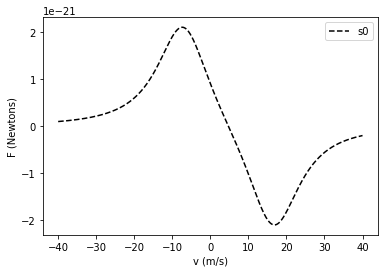

In [75]:
# Proof that pushHelper works.
varr = np.linspace(-40, 40, 10000)
x = 0
s00 = s0

plus, minus = getDeltaPMpusher(x, varr, det_push, det_counter, 0)

fplus, fminus = pushHelper(plus, minus, det_push, det_counter, s00)

plt.plot(varr, fplus-fminus, label="s0", ls="--", c="k")
plt.xlabel("v (m/s)")
plt.ylabel("F (Newtons)")
plt.legend()

## 1D MOT Sanity Check

In [81]:
def forceRadiative_x(x0, v0, axis=0):    
    # Check axis:
    det = np.NaN
    bgrad = np.NaN
    r_squared = np.NaN
    if axis == 0:
        det = det_x
        bgrad = bgrad_x
    elif axis == 1:
        det = det_y
        bgrad = bgrad_y
    elif axis == 2:
        print("do nothing") 
    
    # Compute Delta_{pm}
    Delta_plus, Delta_minus = getDeltaPM(x0, v0, det, bgrad)
    
    # Compute s_adjusted, which is s0 * e^{-2r^2/w^2}
    r_squared = 0 # FOR NOW, NO BEAM WAIST
    s_adjusted = s0 * np.exp(-2*r_squared/(cooling_waist**2))
    
    # Compute Force
    force = radiativeHelper(Delta_plus, Delta_minus, det, s_adjusted)
    
    return force

def runEuler_x(x0, v0, m=mass_Rb87, dt=10 * 10**(-6), num_timesteps=1000, axis=0):
    # Initialize state:
    xn = x0
    vn = v0

    # Data storage
    positions = []
    positions.append(xn)  # Store x0
    velocities = []
    velocities.append(vn) # Store v0
    times = []
    times.append(0)
    forces = []
    forces.append(0)
    

    # Euler Loop
    for j in range(0, num_timesteps):
        force = forceRadiative_x(xn, vn, axis=axis)
        forces.append(force)
        vdot = force/m
        #print("4) vdot", vdot)
        vn = vn + dt*vdot
        #print("5) vn", vn)
        xn = xn + dt*vn

        # Update storage
        positions.append(xn)
        velocities.append(vn)
        times.append((j+1)*dt)
     
    return np.array(times), np.array(positions), np.array(velocities), np.array(forces)

def runRK4_x(force, x0, v0, m=mass_Rb87, dt=10 * 10**(-6), num_timesteps=1000):
    # Initialize state:
    xn = x0
    vn = v0
    
    # Data storage
    positions = []
    positions.append(xn)  # Store x0
    velocities = []
    velocities.append(vn) # Store v0
    times = []
    times.append(0)
    
    # RK4 Loop
    for j in range(0, num_timesteps):
        K1 = force(xn, vn)/m
        L1 = vn
        
        K2 = force(xn + dt*L1/2, vn + dt*K1/2)/m
        L2 = vn + dt*K1/2
        
        K3 = force(xn + dt*L2/2, vn + dt*K2/2)/m
        L3 = vn + dt*K2/2
        
        K4 = force(xn + dt*L3, vn + dt*K3)/m
        L4 = vn + dt*K3
        
        # Update xn and vn
        xn = xn + (dt/6)*(L1 + 2*L2 + 2*L3 + L4)
        vn = vn + (dt/6)*(K1 + 2*K2 + 2*K3 + K4)
        
        
        # Store these new xn, vn:
        positions.append(xn)
        velocities.append(vn)
        times.append((j+1) * dt)
    
    return np.array(times), np.array(positions), np.array(velocities)

Text(0, 0.5, 'F (N)')

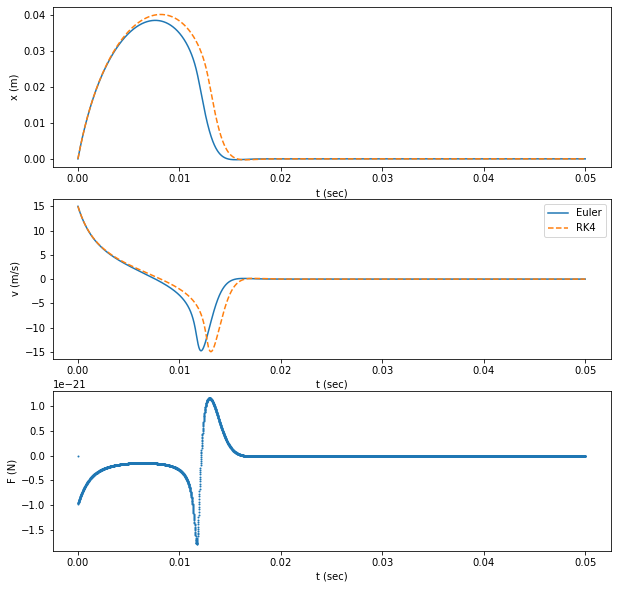

In [82]:
# Radiative force should caused damped harmonic oscillator for small x_0, small v_x.
# Testing:
num_time = 5000

# Initialize an atom with these velocities
x0 = 0

vx = 15 # m/s

tt, xx, vv, ff = runEuler_x(x0, vx, num_timesteps=num_time)
ttt, xxx, vvv = runRK4_x(forceRadiative_x, x0, vx, num_timesteps=num_time)

# positions
fig, ax = plt.subplots(3, 1, figsize=(10, 10))

# x-pos
ax[0].plot(tt, xx, label="Euler")
ax[0].set_xlabel("t (sec)")
ax[0].set_ylabel("x (m)")

ax[0].plot(ttt, xxx, label="RK4", ls="--")

#v-pos
ax[1].plot(tt, vv, label="Euler")
ax[1].set_xlabel("t (sec)")
ax[1].set_ylabel("v (m/s)")
ax[1].plot(ttt, vvv, label="RK4", ls="--")
ax[1].legend()

ax[2].scatter(tt, ff, s = 1)
ax[2].set_xlabel("t (sec)")
ax[2].set_ylabel("F (N)")